In [15]:
import re
import os
from collections import defaultdict

import wandb
import numpy as np
from omegaconf import OmegaConf as om
import matplotlib.pyplot as plt

In [16]:
api = wandb.Api()
project_name = "mosaic-ml/neural-data-filtering"

In [39]:
# Baseline vs offline comparison
groups = {
    "mpt-passes-1-final-3B-52B-baseline": "baseline",
    "mpt-passes-1-final-3B-52B-offline-hard-0.5-ref-125M-26B": "offline-global",
    "mpt-passes-1-final-3B-52B-offline-local-hard-0.5-ref-125M-26B": "offline-local",
}

# PILE Baseline vs offline comparison
groups = {
    "pile-passes-0.5-final-1B-26B-baseline": "baseline",
    "pile-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-125M-26B": "offline-global",
}

# 2.5 vs 1.4 epoch comparisons
# groups = {
#     "mpt1.5-3b-params-52b-tokens-1.4x-epoch-raw-proportion": "raw-mix-5T-setting",
#     "mpt1.5-3b-params-52b-tokens-2.5x-epoch-raw-proportion": "raw-mix-10T-setting",
# }

In [40]:
raw = False
filters = {}

In [41]:
runs = api.runs(project_name, filters=filters)

In [42]:
categories = ["average", "world_knowledge", "commonsense_reasoning", "language_understanding", "symbolic_problem_solving", "reading_comprehension"]
metric_names = [os.path.join("icl", "metrics", f"{'raw_' if raw else ''}eval_gauntlet", category) for category in categories[1:]]

In [43]:
raw_group_results = {group: defaultdict(list) for group in groups.keys()} 
for run in runs:
    group = run.group
    name = run.name


    if group not in groups:
        continue
    
    history = run.scan_history(keys=metric_names + ["time/batch"])
    for row in history:
        # try:
        batch = row["time/batch"]
        metrics = [row[metric_name] for metric_name in metric_names] 
        average = np.mean(metrics) 
        metrics = [average] + metrics
        raw_group_results[group][batch].append(metrics)
        # except Exception as e:
        #     print(f"Failed for run: {name}")
        #     print(f"Exception: {e}")

In [44]:
group_results = {k: {step: np.mean(metrics, axis=0) for step, metrics in v.items()} for k, v in raw_group_results.items()}

| average | world_knowledge | commonsense_reasoning | language_understanding | symbolic_problem_solving | reading_comprehension |
| baseline | 0.1367 | 0.1221 | 0.1609 | 0.1248 | 0.0835 | 0.1921 |
| offline-global | 0.1329 | 0.1207 | 0.1427 | 0.1274 | 0.0826 | 0.1913 |


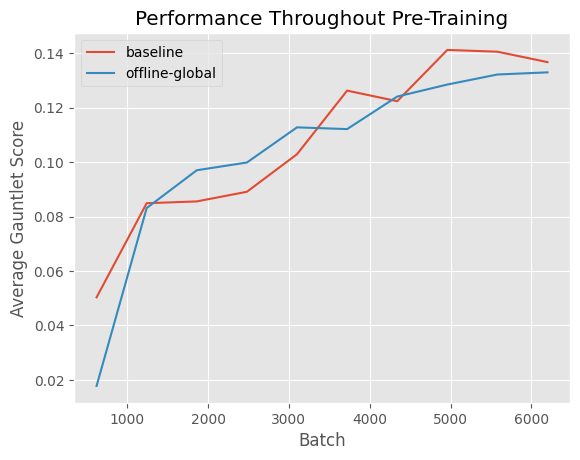

In [45]:
plt.style.use('ggplot')
print("| " + " | ".join(categories) + " |")
for run_name, step_metrics in group_results.items():
    steps = sorted(step_metrics.keys())
    averages = [step_metrics[step][0] for step in steps]
    plt.plot(steps, averages, label=groups[run_name])
    metrics = step_metrics[steps[-1]].tolist()
    metrics = [f"{metric:.4f}" for metric in metrics]
    print(f"| {groups[run_name]} | {' | '.join(metrics)} |")
plt.legend()
plt.ylabel("Average Gauntlet Score")
plt.xlabel("Batch")
plt.title("Performance Throughout Pre-Training")
plt.show()